## Qiskit quantum neural network (QNN) tutorial

### Create the neural network ansatz
We use the same ansatz from the QCNN tutorial: https://qiskit-community.github.io/qiskit-machine-learning/tutorials/11_quantum_convolutional_neural_networks.html 

We define a two-qubit unitary that represents a single convolutional layer. It consists of a series of quantum gates applied to the qubits.
Specifically, it applies rotations around the Z-axis (rz), rotations around the Y-axis (ry), and controlled-X (cx) gates to create entanglement and perform operations on the qubits.

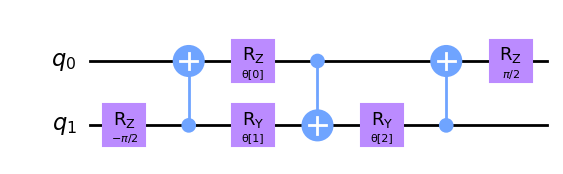

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


# We define a two qubit unitary
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

We now build the convolutional layer by composing multiple instances of the conv_circuit between adjacent qubits in pairs, creating a series of entanglements and operations.

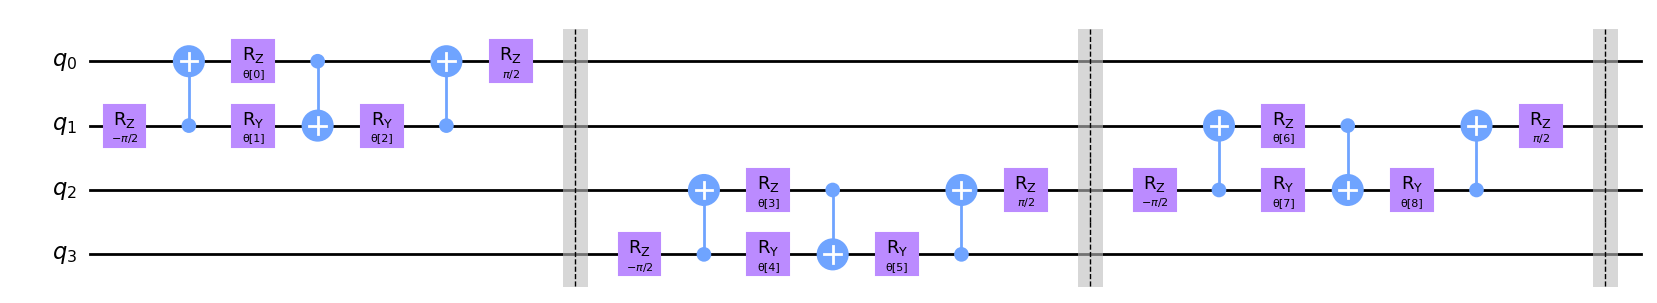

In [2]:
# We construct a full convolutional layer using conv_circuit for pairs of qubits.
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

We perform a pooling operation by applying rotations and controlled-X gates to combine information from pairs of qubits.

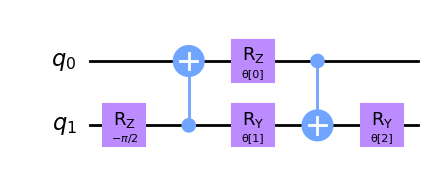

In [3]:
# This defines a quantum circuit representing a single pooling layer.
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

Them we construct a pooling layer by composing instances of the pool_circuit between source and sink qubits, creating a condensed representation of the data.

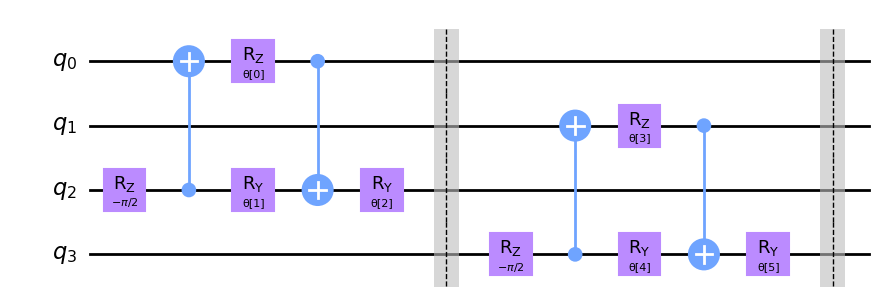

In [4]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

### Generate the data
We randomly generate a dataset consisting of images with horizontal and vertical lines. Images with horizontal lines are labeled -1 and vertical with +1.

The function constructs these images by randomly selecting patterns of horizontal and vertical lines and adding noise to the data.

In [5]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = np.random.randint(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = np.random.randint(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = np.random.randint(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = np.random.rand() * np.pi / 4
    return images, labels

In [6]:
from sklearn.model_selection import train_test_split


np.random.seed(42)
images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

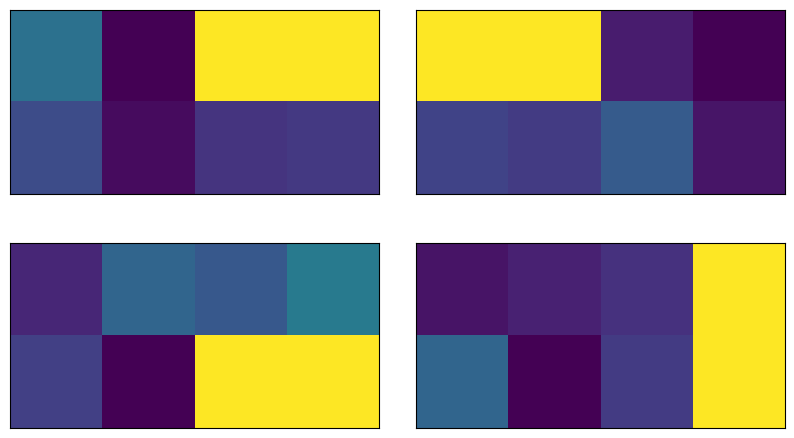

In [7]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

### Create the circuit
Now we build the circuit by combining the feature map for the data encoding and the ansatz.

In [8]:
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp

# This serves as the feature map for encoding our input data into quantum states.
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")
# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)
# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)
# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)
# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)
# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)
# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

### Load the data and do a forward pass
We create a function to run a forward pass of our quantum neural network on a small batch of the dataset. This allows us to test the network's initial predictions with randomly initialized ansatz parameters.

In [9]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator
from typing import Sequence


def forward(circuit: QuantumCircuit,
            input_params: np.ndarray, 
            weight_params: np.ndarray, 
            estimator: BaseEstimatorV2,
            observables: Sequence[BaseOperator] | BaseOperator
) -> np.ndarray:
    """
    Forward pass of the neural network.
    
    circuit: circuit consisting of data loader gates and the neural network ansatz.
    input_params: data encoding parameters.
    weight_params: neural network ansatz parameters.
    estimator: EstimatorV2 primitive. 
    observables: a single oberservable or a sequence of observables to compute the expectation over.

    output: an array (for one observable) or a matrix (for a sequence of observables) of expectation values.
    Rows correspond to observables and columns to data samples.
    """
    num_samples = input_params.shape[0]
    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    parameters = np.concatenate((input_params, weights), axis=1)
    job = estimator.run(
        [circuit] * num_samples * len(observables),
        [op for op in observables for _ in range(num_samples)],
        np.tile(parameters, (len(observables), 1)),
    )
    results = job.result()
    results_postprocessed = np.squeeze(np.reshape(results.values, (-1, num_samples)))
    
    return results_postprocessed

Example forward pass with two images from the dataset and randomly initialized ansatz parameters.

In [10]:
from qiskit.primitives import Estimator


np.random.seed(42)

result = forward(circuit=circuit, 
                 input_params=np.array(train_images[:2]), 
                 weight_params=np.random.rand(len(ansatz.parameters)) * 2 * np.pi, 
                 estimator=Estimator(), 
                 observables=observable)
print(result)

[0.07978917 0.08644573]


### TODO: Gradient with parameter shift rule
We will implement one example gradient function to be used with gradient-based optimizers. For now, we skip the two cells below and use a gradient-free optimizer such as COBYLA.

In [11]:
def param_shift_estimator_gradient(circuit: QuantumCircuit,
                                   input_params: np.ndarray, 
                                   weight_params: np.ndarray, 
                                   estimator: BaseEstimatorV2,
                                   observable: BaseOperator
) -> np.ndarray:
    """
    Compute the gradients of the expectation values by the parameter shift rule [1].

    **Reference:**
    [1] Schuld, M., Bergholm, V., Gogolin, C., Izaac, J., and Killoran, N. Evaluating analytic
    gradients on quantum hardware, `DOI <https://doi.org/10.1103/PhysRevA.99.032331>`_
    """
    num_samples = input_params.shape[0]
    num_input_params = input_params.shape[1]
    num_weight_params = len(weight_params)

    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    parameters = np.concatenate((input_params, weights), axis=1)
    job = estimator.run(
        [circuit] * num_samples * len(observables),
        [op for op in observables for _ in range(num_samples)],
        np.tile(parameters, (len(observables), 1)),
    )
    results = job.result()
    results_postprocessed = np.reshape(results.values, (-1, num_samples)).T
    
    return results_postprocessed

In [12]:
np.random.seed(12345)

input_params = np.array([train_images[0], train_images[1]])
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
estimator = Estimator()
observables = [observable, observable]

result = param_shift_estimator_gradient(circuit, input_params, weight_params, estimator, observables)
print(result)

[[ 0.04742064  0.04742064]
 [-0.0034983  -0.0034983 ]]


### Loss function
The loss function computes the Mean Squared Error (MSE) loss between the predictions and the true labels, providing a measure of the model's performance.

In [13]:
def mse_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Compute the L2 loss averaged over samples, i.e. mean squared error (MSE).

    prediction: predictions from the forward pass of neural network.
    target: true labels.

    output: MSE loss.
    """
    if len(predict.shape) <= 1:
        return ((predict - target) ** 2).mean()
    else:
        return (np.linalg.norm(predict - target, axis=tuple(range(1, len(predict.shape)))) ** 2).mean()

Example run of the loss function.

In [14]:
batch_size = 2
train_images_batch = np.array(train_images[:batch_size])
train_labels_batch = np.array(train_labels[:batch_size])
print(f"True labels: {train_labels_batch}")

np.random.seed(42)

pred_batch = forward(circuit=circuit, 
                     input_params=train_images_batch, 
                     weight_params=np.random.rand(len(ansatz.parameters)) * 2 * np.pi,
                     estimator=Estimator(),
                     observables=observable)
print(f"Predictions: {pred_batch}")

loss = mse_loss(predict=pred_batch, target=train_labels_batch)
print(f"Loss: {loss}")

True labels: [-1 -1]
Predictions: [0.07978917 0.08644573]
Loss: 1.1731544776258447


### Cost function
This function takes in the ansatz parameters, executes the forward pass, computes the loss and updates the objective_func_vals list to track the loss values during optimization.

In [15]:
def cost_function(weight_params: np.ndarray) -> np.ndarray:
    """
    Cost function for the optimizer to update the ansatz parameters.

    weight_params: ansatz parameters to be updated by the optimizer.

    output: MSE loss.
    """
    predictions = forward(circuit=circuit, 
                          input_params=input_params, 
                          weight_params=weight_params, 
                          estimator=estimator, 
                          observables=observables)
    
    cost = mse_loss(predict=predictions, 
                    target=target)
    objective_func_vals.append(cost)
    
    global iter
    if iter % 20 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1

    return cost

Initial variables for the cost function.

In [16]:
# Globals
circuit = circuit
input_params = train_images_batch
estimator = Estimator()
observables = observable
target = train_labels_batch
objective_func_vals = []
iter = 0

Example run of the cost function.

In [17]:
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
cost_function(weight_params)

Iter: 0, loss: 1.1731544776258447


1.1731544776258447

### Optimizer
Now we run the optimizer once for a small batch from the training data.

In [18]:
from scipy.optimize import minimize


res = minimize(cost_function, weight_params, method='COBYLA', options={'maxiter': 200})
print(res)

Iter: 20, loss: 0.926837151448145
Iter: 40, loss: 0.7839401681551739
Iter: 60, loss: 0.45608099568518423
Iter: 80, loss: 0.3213908781142454
Iter: 100, loss: 0.4455380520521984
Iter: 120, loss: 0.2403280610249491
Iter: 140, loss: 0.40947900034840695
Iter: 160, loss: 0.17852604823293025
Iter: 180, loss: 0.17145731412690118
Iter: 200, loss: 0.12208027967390969
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 0.11442616374467268
       x: [ 4.470e+00  5.489e+00 ...  6.736e+00  6.508e+00]
    nfev: 200
   maxcv: 0.0


### Accuracy
After training, we evaluate the model's accuracy on both the training and testing datasets.

The predicted labels are compared with the true labels to measure the model's classification performance.

In [19]:
print(res['x'])
pred_batch = forward(circuit, train_images_batch, res['x'], estimator, observable)
print(pred_batch)

[ 4.4698491   5.48904007  5.62967895  4.28359915  1.06499259  0.65348477
  0.49894749  5.1492606   4.91093534  5.82651108 -0.13854687  5.80622911
  4.83666198  1.6346757   2.07295443  1.20100855  1.85659262  3.16836139
  3.950659    1.80124989  4.94511107  0.99020426  1.48789907  2.35811994
  2.94661423  4.93340606  2.95698208  3.34469046  3.72225051  0.63569364
  3.71817958  0.76210549  1.36989593  6.71546518  6.11146922  4.9220941
  1.61003117  0.49112791  4.27278971  2.66609709  1.80125177  3.18374165
  0.22307868  6.02403932  1.93132931  3.90827678  1.73607055  4.23670654
  3.31707762  1.23304177  7.3650075   5.08952153  6.73616309  6.50752064]
[-0.67677817 -0.64732455]


Cutoff at 0 for classification.

In [20]:
import copy


pred_labels_batch = copy.deepcopy(pred_batch)
pred_labels_batch[pred_labels_batch >= 0] = 1
pred_labels_batch[pred_labels_batch < 0] = -1

print(f"Predicted labels: {pred_labels_batch}")
print(f"True labels: {train_labels_batch}")

Predicted labels: [-1. -1.]
True labels: [-1 -1]


Accuracy over the batch of training samples.

In [21]:
from sklearn.metrics import accuracy_score


accuracy = accuracy_score(train_labels_batch, pred_labels_batch)
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 100.0%


### Training Loop
The model is trained in a loop over multiple epochs and batches of the training dataset.

For each epoch, the dataset is divided into batches, and the cost function is minimized to update the ansatz parameters.

In [22]:
batch_size = 35
num_epochs = 1
num_samples = len(train_images)

# Globals
circuit = circuit
estimator = Estimator()
observables = observable
objective_func_vals = []
iter = 0

# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi

for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        train_images_batch = np.array(train_images[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        res = minimize(cost_function, weight_params, method='COBYLA', options={'maxiter': 2000})
        weight_params = res['x']



Epoch: 0, batch: 0
Iter: 0, loss: 0.996252305601312
Iter: 20, loss: 0.917675168391386
Iter: 40, loss: 0.8688243739187305
Iter: 60, loss: 0.8556701067093485
Iter: 80, loss: 0.8375351595815245
Iter: 100, loss: 0.8454072616261528
Iter: 120, loss: 0.8005938868457279
Iter: 140, loss: 0.7926345573472136
Iter: 160, loss: 0.7727504556647671
Iter: 180, loss: 0.7610439535961859
Iter: 200, loss: 0.7798559926274135
Iter: 220, loss: 0.7501593752089804
Iter: 240, loss: 0.7494368638763067
Iter: 260, loss: 0.7337325960096781
Iter: 280, loss: 0.7027422258539815
Iter: 300, loss: 0.6900648361702398
Iter: 320, loss: 0.6852404408639655
Iter: 340, loss: 0.6828867539919593
Iter: 360, loss: 0.674395697414182
Iter: 380, loss: 0.6791306673198683
Iter: 400, loss: 0.6684201014749194
Iter: 420, loss: 0.6698603265454836
Iter: 440, loss: 0.6667248860790286
Iter: 460, loss: 0.6599829535197639
Iter: 480, loss: 0.6516956847768739
Iter: 500, loss: 0.6475745061510821
Iter: 520, loss: 0.6405007697232635
Iter: 540, loss: 0

### Testing and accuracy

In [23]:
from sklearn.metrics import accuracy_score


pred_train = forward(circuit, np.array(train_images), res['x'], estimator, observable)
print(pred_train)

pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(train_labels)

accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[ 0.17395963  0.64641868  0.0972308   0.41856691  0.60043194 -0.42317253
  0.50025131  0.5849577   0.38265905  0.29307027  0.63583067  0.46638581
 -0.18132254  0.54619     0.30348498  0.56121407 -0.11917699  0.48641444
  0.13601267 -0.14726316  0.52714481  0.41574599 -0.26550128  0.35125787
  0.17671395  0.41011795 -0.23515404 -0.31289162  0.11621572 -0.42551755
  0.18959378 -0.29881172  0.47296923  0.50972014  0.67056773]
[ 1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.
  1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1. -1.  1. -1.  1.  1.  1.]
[-1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1]
Train accuracy: 88.57142857142857%


In [24]:
from sklearn.metrics import accuracy_score


pred_test = forward(circuit, np.array(test_images), res['x'], estimator, observable)
print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(test_labels)

accuracy = accuracy_score(test_labels, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

[-0.45222457  0.37923048  0.42721207  0.47367738  0.44026058 -0.44097839
  0.41251342  0.53151848  0.43897799  0.01504262  0.3220721   0.62763896
  0.33919788  0.35760814  0.52473398]
[-1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[-1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1]
Test accuracy: 86.66666666666667%


### Visualization
The loss values during optimization are plotted over iterations to visualize the training progress.

The plot provides insights into how the model's performance improves over time as the ansatz parameters are updated.

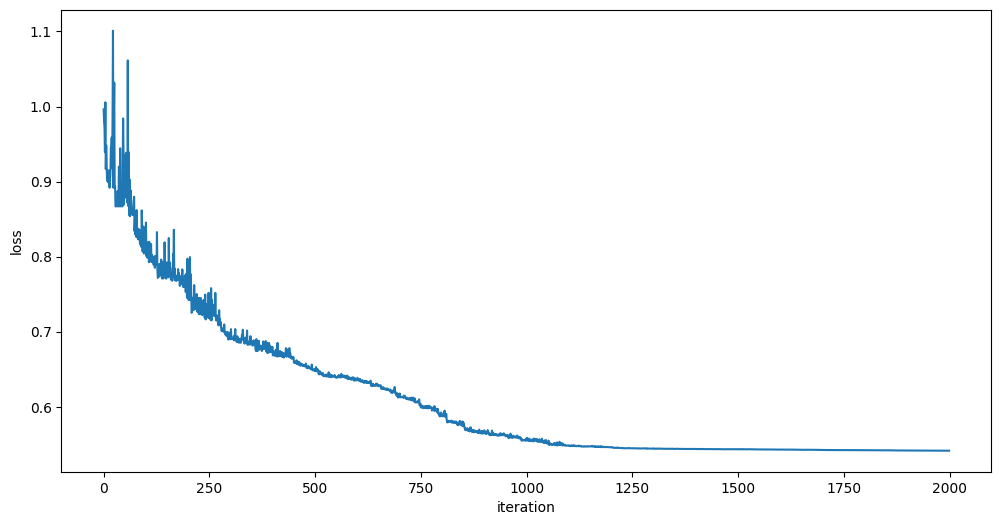

In [25]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

## Scaling up to more qubits

One way we can scale up a quantum neural network (QNN) is by adding more qubits within each layer. 

This involves increasing the number of qubits in the convolutional and pooling layers. 

Here's a overview of how you can achieve this:

### Convolutional Layers
To increase the number of qubits per layer, we must modify the convolutional layers in order to operate on more qubits at a time. 

For example, if we have a 2-qubit convolution, we can expand it to a 4-qubit convolution.

To do this we must:
- Define new sets of qubit pairs for the expanded convolution operation.
- Update the convolution circuit function to incorporate these new qubit pairs.
- Modify the parameter handling to accommodate the increased number of parameters needed for the expanded convolutional operations.

### Pooling Layers
When scaling up, we have to update the pooling circuit function to accommodate our new larger sets of qubits.

### Optimization and Training

With more qubits per layer, the number of trainable parameters in the QNN will grow. This requires more careful optimization during training.